# Project Topic:Ranking of Academic Papers


## Loading the DBLP-Citation-network V10 data into dataframes

In [146]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
#Please change the nrows to 1 million if need is to test for entire dataset.
def load_df(csv_path='./dblp-ref-1_full.csv', nrows=1000000):
    train = pd.read_csv(csv_path, nrows=1000000)
    train['authors'] = train['authors'].fillna("[]")
    train['references'] = train['references'].fillna("[]")
    train[['authors', 'references']] = train[['authors', 'references']].applymap(literal_eval)
#     train.reset_index(level=0, inplace=True)
#     train.head()
    return train

In [147]:
train_df = load_df()
train_df.head()


,index,abstract,authors,id,n_citation,references,title,venue,year,F1,F2,F3
0,0,Based on biological control strategy in pest m...,"[Guoping Pang, Lansun Chen]",4aa69add-3978-480b-a1c0-d99a83d7e324,8,"[04754a28-6bf4-4d5d-8e42-2677d8564cdc, 33a877a...",Dynamic analysis of a pest-epidemic model with...,Mathematics and Computers in Simulation,2008,mathematics,mathematical optimization,control theory
1,1,Abstract#R##N##R##N#Regression testing is an i...,"[Anneliese von Mayrhauser, Ning Zhang]",4aa69b49-9bfc-49c3-81a7-7af5c215ca0e,50,"[2932090c-8204-4970-bd27-98a66155011c, 9479c8d...",Automated regression testing using DBT and Sleuth,Journal of Software Maintenance and Evolution:...,1999,computer science,reliability engineering,system testing
2,2,Mobile applications are software packages that...,"[Zheng Yan, Peng Zhang, Robert H. Deng]",4aa69de5-c819-482e-a808-2b3f8b829008,53,"[012d9aaf-34d0-496a-99c0-f0fd15dd2984, 029be9a...",TruBeRepec: a trust-behavior-based reputation ...,ubiquitous computing,2012,computer science,data mining,computer security
3,3,We propose a method that allows opportunistic ...,"[Jarkko Kaleva, Petri Komulainen, Markku J. Ju...",4aa6a255-c72c-4ccf-b1b8-c048ba39255b,0,"[1322cb89-dda2-4625-8c80-6863810d5c3f, 1eddb4e...",Zero-forcing spatial interweave with greedy sc...,wireless personal multimedia communications,2011,computer science,real time computing,scheduling
4,4,This article studies the power allocation (PA)...,"[Yingnan Zhang, Qiao Wang]",4aa6bae5-bbd9-46a1-944a-18ed700b72d5,50,"[0b480a7b-b171-4bf6-846c-1c7478a6d279, 0fd4be7...",Optimal power control of parallel orthogonalfr...,Iet Communications,2011,mathematics,real time computing,computer network


### clean the data by dropping unecessary columns

In [148]:
print(train_df.describe())
train_df = train_df.drop(columns=['abstract'])

                index      n_citation            year
count  1000000.000000  1000000.000000  1000000.000000
mean    499999.500000       40.967692     2006.941511
std     288675.278933      144.318093        8.104700
min          0.000000        0.000000     1936.000000
25%     249999.750000        2.000000     2004.000000
50%     499999.500000       23.000000     2009.000000
75%     749999.250000       50.000000     2013.000000
max     999999.000000    26357.000000     2017.000000


# 1. Calculating h-index for authors

### Method to calculate h-index:
1. We construct a Paper citation graph which has paper ids as nodes and citations as edges.
2. A map of authors and list of published papers is created.
3. Another map of authors and citation count of the published papers is created.
4. h-index of each author is obtained by passing the citation count array of each author to get_h_index() function.

In [107]:
def get_h_index(citations):
#     Creating a dict of paper id and its references
    citations.sort()
    n = len(citations)
    for i in range(n):
        if citations[i] >= (n-i):
            return n-i
    return 0
        
    
    
    
#     create author-papers map
#     get citation count of a paper from Graph
#     create citation array for each author
#     calculate h-index for each author, put it in a map
def get_author_paper_map(df, G):
    author_paper_map = dict()
    author_papercitations_map = dict()
    df['authors'] = df['authors'].fillna("NA")
    
    authors_all = df.authors.tolist()
    for i in range(0, len(authors_all)):
        if authors_all[i] is not 'NA':
            authors = authors_all[i]
            for j in range(0, len(authors)):
                author = authors[j]
    #             print (author)
                if author not in author_paper_map:
                    author_paper_map[author] =  set()
                    author_paper_map[author].add(df.id[i])
                    author_papercitations_map[author] =  []
                    author_papercitations_map[author].append(len(list(G.predecessors(df.id[i]))))
                else:
                    author_paper_map[author].add(df.id[i])
                    author_papercitations_map[author].append(len(list(G.predecessors(df.id[i]))))
                
#     print (author_paper_map)
    return author_paper_map ,author_papercitations_map


## Code to construct citation network

In [108]:
import networkx as nx
def get_paper_graph(df):
    G = nx.DiGraph()
#     G.add_node(1)
    G.add_nodes_from(df.id)
    for i in range (0, len((df.id))):#len((df.id))
#         print (len(df.references[0]))
        paper_id = df.id[i]
        if(df.references[i] is "NA"):
            continue  
        for j in range(0, len(df.references[i])):
            refs= df.references[i]
            G.add_edge(paper_id, refs[j])
    return G
    

train_df['references'] = train_df['references'].fillna("NA")
# G=get_paper_graph(train_df)
# print("Edges Count:"+str(len(list(G.edges))))




#### Pickle the citation graph

In [ ]:
import pickle
file_Name = "PaperGraph_1.pickle"
# open the file for writing
fileObject = open(file_Name,'wb') 

# this writes the object a to the
# file named 'testfile'
# pickle.dump(G,fileObject)   

# here we close the fileObject
# fileObject.close()
# we open the file for reading
# fileObject = open(file_Name,'r')  
# # load the object from the file into var b
# b = pickle.load(fileObject)  

In [119]:

# pr_page = nx.pagerank(G)
# # print(pr_page)
# with open('pr_papers.txt', 'w') as file:
#      file.write(json.dumps(pr_page)) # use `json.loads` to do the reverse
with open('pr_papers1M.txt', 'r') as f:
#     file.write(json.dumps(pr_page)) # use `json.loads` to do the reverse
    pr_page = json.load(f)

In [ ]:
# train_df=train_df[0:1000]
# print("Edges Count:"+str(len(list(G.edges))))
# author_paper_map, author_papercitations_map = get_author_paper_map(train_df, G)
# print(len(author_papercitations_map))

In [110]:
def get_author_h_index(author_papercitations_map):
    author_h_index_map = {}
    for author, citations in author_papercitations_map.items():
        h_index= get_h_index(citations)
        author_h_index_map[author] =  h_index
    return author_h_index_map

# author_h_index_map = get_author_h_index(author_papercitations_map)
# print("Authors with h-index>20")
# for author, h_index in author_h_index_map.items():
#        if h_index>20:
#             print (author + ":"+ str(h_index))
# print(len(author_papercitations_map))

import json

# with open('h_index_dump10000.txt', 'w') as file:
#      file.write(json.dumps(author_h_index_map)) # use `json.loads` to do the reverse
        
with open('h_index_dump1M.txt', 'r') as file:
#     file.write(json.dumps(pr_page)) # use `json.loads` to do the reverse
    author_h_index_map = json.load(file)

In [121]:
def get_per_field_papers(df=train_df, field='artificial intelligence'):
     
    rows_relevant = df.loc[(df['F1'] == field) | (df['F2'] == field) | (df['F3'] == field)]
#     print (len(rows_relevant))
    rows_relevant = rows_relevant[['id','title']]
    return rows_relevant

In [158]:
def get_authors_by_field(df=train_df, field='artificial intelligence', threshold=5):
    rows_relevant = df.loc[(df['F1'] == field) | (df['F2'] == field) | (df['F3'] == field)]
    authors = []
#     print(rows_relevant.authors)
    rows_relevant['authors'] = rows_relevant['authors'].fillna("NA")
    auth = rows_relevant.authors.reset_index(drop=True)
    
#     authors.extend(l)
    for l in auth:#len(rows_relevant):
#         print(l)
        if l is not 'NA':
#         auth_list = list(rows_relevant.authors[i])
            authors.extend(l)
    authors_df = pd.DataFrame({'authors':authors})
    authors_df = authors_df.groupby("authors").filter(lambda x: len(x) >= threshold)
#     authors_set= set(authors)
#     print(len(authors_df))
#     qualifying_authors = []
#     for a in authors_set:
#         if (authors.count('a')>15):
#             qualifying_authors.append(a)
            
#     print('Total authors for field ' + field + ': '+str(len(qualifying_authors)))
    qualifying_authors =  authors_df['authors'].values.tolist()
    qualifying_authors= set(qualifying_authors)
    return list(qualifying_authors)
get_authors_by_field(train_df,'combinatorics') 

C:\Users\Vaibhav\Anaconda3_DSF\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


['Shiying Wang',
 'Burkhard Monien',
 'Frank Ruskey',
 'Svatopluk Poljak',
 'Bing Wei',
 'Pavol Hell',
 'Bernd Sturmfels',
 'Xi Zhang',
 'Mikael Skoglund',
 'Mike J. Grannell',
 'Sungyoung Lee',
 'Hui Yu',
 'Matthias Patzold',
 'Andrzej Lingas',
 'Igor E. Shparlinski',
 'Weifan Wang',
 'S. Muthukrishnan',
 'C. A. Rodger',
 'Jie Wang',
 'Ramesh Hariharan',
 'Wei Xiang',
 'Takeshi Tokuyama',
 'Michael Stiebitz',
 'Tony F. Chan',
 'Michael T. Goodrich',
 'Min Li',
 'Hui Li',
 'Andrew Zisserman',
 'Chandrajit L. Bajaj',
 'Gilbert Laporte',
 'Oleg V. Borodin',
 'Daniela Rus',
 'Jeff Erickson',
 'Gary McGraw',
 'Bruce A. Reed',
 'N. J. A. Sloane',
 'Tsuhan Chen',
 'Johan Håstad',
 'Romeo Rizzi',
 'Yu Chen',
 'Henry M. Walker',
 'Zsolt Tuza',
 'Tran van Trung',
 'Benjamin Doerr',
 'Stefan Langerman',
 'Bruce L. Golden',
 'Ming Li',
 'Li Chen',
 'Peter J. Slater',
 'Bill Jackson',
 'Martin Loebl',
 'Chew Lim Tan',
 'Derek G. Corneil',
 'Irfan Awan',
 'Emilio Luque',
 'George W. A. Milne',
 'Jo

In [187]:
def get_h_index_per_field(field = 'artificial intelligence', threshold=5 ):
    print("received field:"+field)
    authors = get_authors_by_field(train_df, field, threshold)
    field_h_index_map = {}
    for i in range(0, len(authors)):
        if authors[i] in author_h_index_map:
            field_h_index_map[authors[i]] = author_h_index_map[authors[i]]
    
#     print(len(field_h_index_map))
#     for author, h_index in field_h_index_map.items():
#         if h_index>1:
#             print (author + ":"+ str(h_index))
    count =0
#     print ('TOP 100 AUTHORS for field:'+ field+' by h-Index are:')
    authors_list = []
    h_list = []
    for w in sorted(field_h_index_map, key=field_h_index_map.get, reverse=True):
#         print (w, field_h_index_map[w])
        authors_list.append(w)
        h_list.append(field_h_index_map[w])
        count +=1
        if(count==100):
            break
    df_result = pd.DataFrame({'authors':authors_list})
    df_h_index = pd.DataFrame({'h_index':h_list})
    df_result['h_index'] =  df_h_index
#     print (df_result.head(50))
    return df_result
    
h_index_AI = get_h_index_per_field(field = 'artificial intelligence')
h_index_AI.head()

received field:artificial intelligence


C:\Users\Vaibhav\Anaconda3_DSF\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,authors,h_index
0,Anil K. Jain,33
1,Jiawei Han,29
2,Christos H. Papadimitriou,28
3,Robert Endre Tarjan,27
4,Jeffrey D. Ullman,27


In [202]:
def get_pr_auth_per_field(field = 'artificial intelligence', threshold=5 ):
    print("received field:"+field)
    authors = get_authors_by_field(train_df, field, threshold)
    field_pr__map = {}
    for i in range(0, len(authors)):
        if authors[i] in author_h_index_map:
            field_pr__map[authors[i]] = pr_auth[authors[i]]
    
#     print(len(field_h_index_map))
#     for author, h_index in field_h_index_map.items():
#         if h_index>1:
#             print (author + ":"+ str(h_index))
    count =0
#     print ('TOP 100 AUTHORS for field:'+ field+' by h-Index are:')
    authors_list = []
    pr_list = []
    for w in sorted(field_pr__map, key=field_pr__map.get, reverse=True):
#         print (w, field_h_index_map[w])
        authors_list.append(w)
        pr_list.append(field_pr__map[w])
        count +=1
        if(count==50):
            break
    df_result = pd.DataFrame({'authors':authors_list})
    df_pr = pd.DataFrame({'pr':pr_list})
    df_result['pr'] =  df_pr
#     print (df_result.head(50))
    return df_result

# Plotting H-index results for authors

received field:artificial intelligence


C:\Users\Vaibhav\Anaconda3_DSF\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

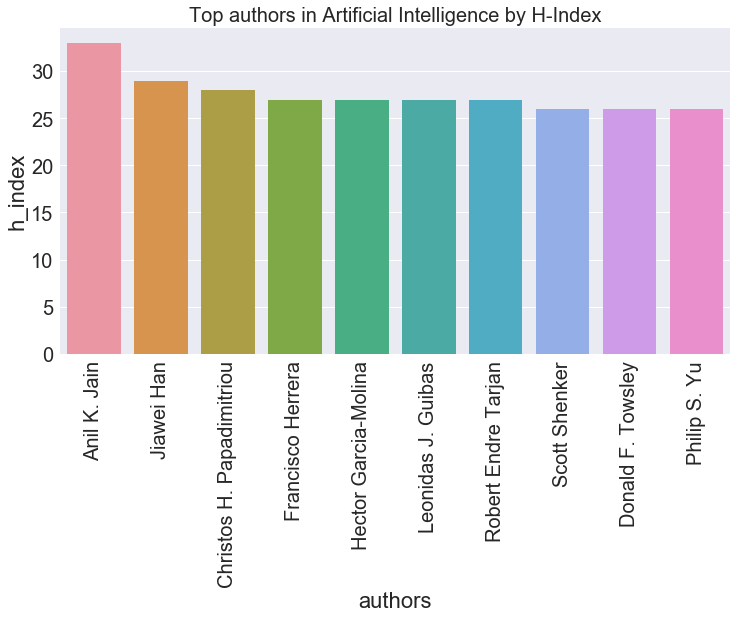

In [188]:
h_index_AI = get_h_index_per_field(field = 'artificial intelligence', threshold =15)

sns.set(rc={'figure.figsize':(12,6)})
sns.set(font_scale = 2)
sns.barplot(x='authors',y='h_index', data=h_index_AI[0:10]).set_title('Top authors in Artificial Intelligence by H-Index',fontsize=20)
 
# Rotate x-labels
plt.xticks(rotation=90)

received field:statistics


C:\Users\Vaibhav\Anaconda3_DSF\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

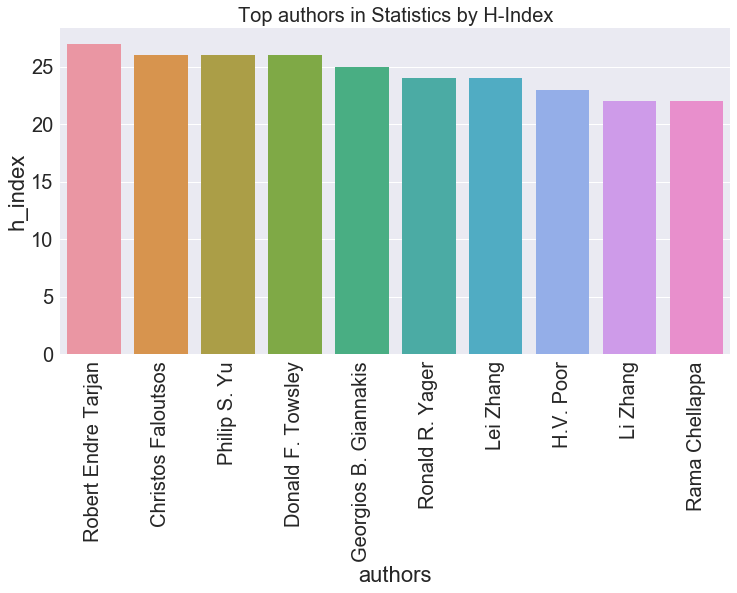

In [196]:
h_index_stat = get_h_index_per_field(field = 'statistics', threshold =5)

sns.set(rc={'figure.figsize':(12,6)})
sns.set(font_scale = 2)
sns.barplot(x='authors',y='h_index', data=h_index_stat[0:10]).set_title('Top authors in Statistics by H-Index',fontsize=20)
 
# Rotate x-labels
plt.xticks(rotation=90)

received field:biology


C:\Users\Vaibhav\Anaconda3_DSF\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

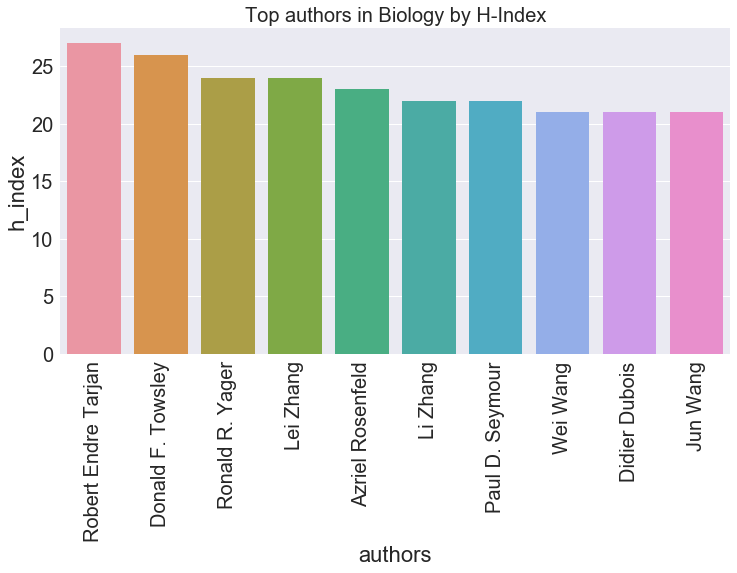

In [195]:
h_index_BIO = get_h_index_per_field(field = 'biology', threshold =10)

sns.set(rc={'figure.figsize':(12,6)})
sns.set(font_scale = 2)
sns.barplot(x='authors',y='h_index', data=h_index_stat[0:10]).set_title('Top authors in Biology by H-Index',fontsize=20)
# Rotate x-labels
plt.xticks(rotation=90)

received field:discrete mathematics


C:\Users\Vaibhav\Anaconda3_DSF\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

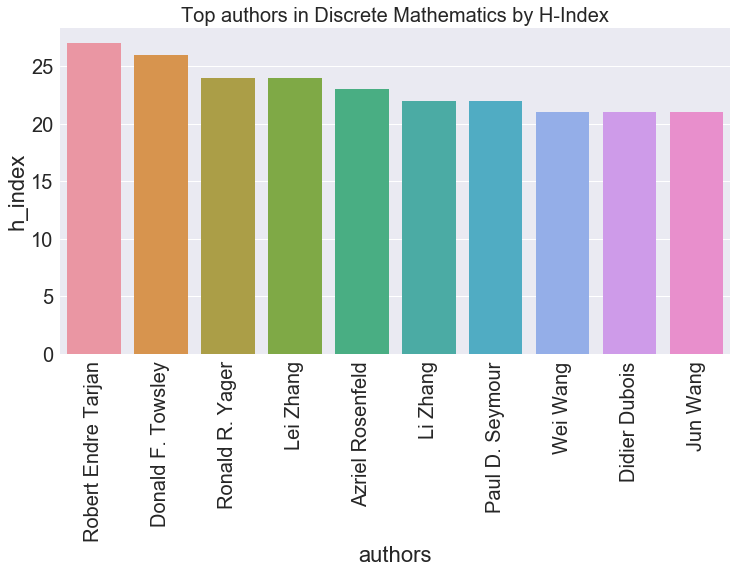

In [193]:
h_index_stat = get_h_index_per_field(field = 'discrete mathematics', threshold =20)

sns.set(rc={'figure.figsize':(12,6)})
sns.set(font_scale = 2)
sns.barplot(x='authors',y='h_index', data=h_index_stat[0:10]).set_title('Top authors in Discrete Mathematics by H-Index',fontsize=20)
 
# Rotate x-labels
plt.xticks(rotation=90)

## PAGE RANK FOR AUTHORS

In [230]:
import networkx as nx
def get_pr_authors(train=train_df):
#     train = train_data[:100]
    #simple page rank for authors
    AG = nx.DiGraph()
    AG.clear()

    for index, row in train.iterrows():
        if(index%1000==0):
            print (index)
        #for each author, add his/her name as a node to the graph
        AG.add_nodes_from(row['authors'])
        rows_ref =[]
        for ref in row['references']:
#                 print(aut)
                #for each reference search the dataframe for the corresponding row
                rows_ref.append(train.loc[train['id'] == ref])
        for aut in row['authors']:
            for cur_row in rows_ref:
                if(len(cur_row) == 1):
#                     print(cur_row)
#                     print("found match")
                    for ref_auth in cur_row['authors']:
                        for ra in ref_auth:
                            AG.add_edge(aut, ra)
    pr_auth = nx.pagerank(AG)
    print(pr_auth)
    return pr_auth


# pr_auth = get_pr_authors()
# with open('prauth_dump.txt', 'w') as file:
#      file.write(json.dumps(author_h_index_map)) # use `json.loads` to do the reverse

# print(pr_auth) 

with open('prauth_dump500k.txt', 'r') as file:
    pr_auth = json.load(file)

# Plotting Page Rank results for authors

received field:discrete mathematics


C:\Users\Vaibhav\Anaconda3_DSF\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

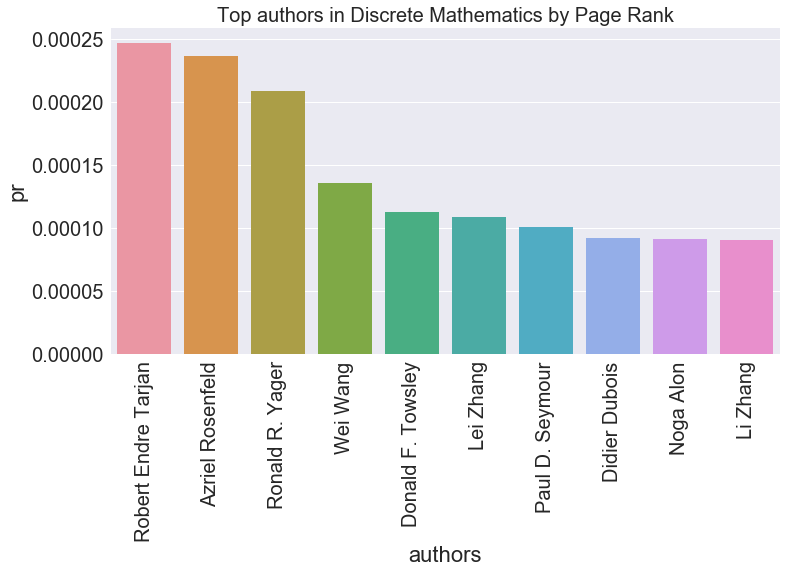

In [234]:
pr_dm = get_pr_auth_per_field(field = 'discrete mathematics', threshold =20)


sns.set(rc={'figure.figsize':(12,6)})
sns.set(font_scale = 2)
sns.barplot(x='authors',y='pr', data=pr_dm[0:10]).set_title('Top authors in Discrete Mathematics by Page Rank',fontsize=20)
 
# Rotate x-labels
plt.xticks(rotation=90)

received field:artificial intelligence


C:\Users\Vaibhav\Anaconda3_DSF\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

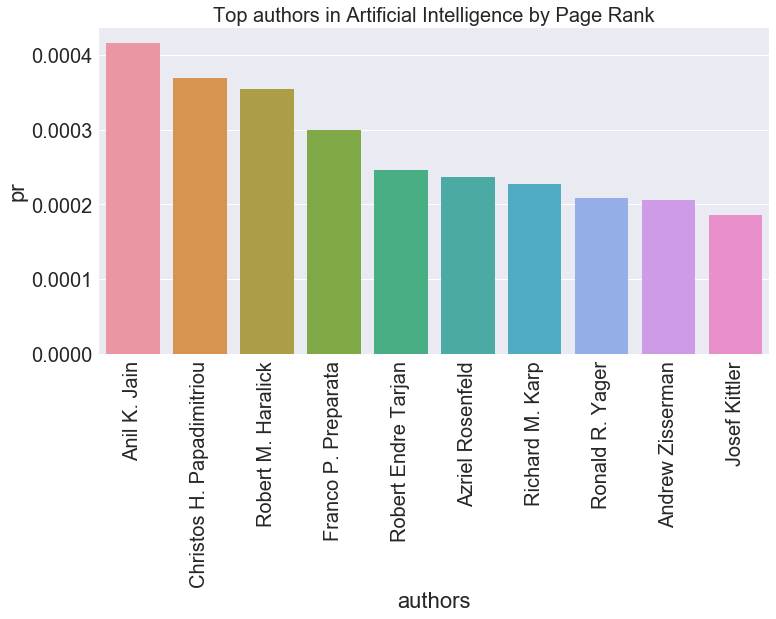

In [231]:
pr_ai = get_pr_auth_per_field(field = 'artificial intelligence', threshold =15)


sns.set(rc={'figure.figsize':(12,6)})
sns.set(font_scale = 2)
sns.barplot(x='authors',y='pr', data=pr_ai[0:10]).set_title('Top authors in Artificial Intelligence by Page Rank',fontsize=20)
 
# Rotate x-labels
plt.xticks(rotation=90)

received field:biology


C:\Users\Vaibhav\Anaconda3_DSF\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

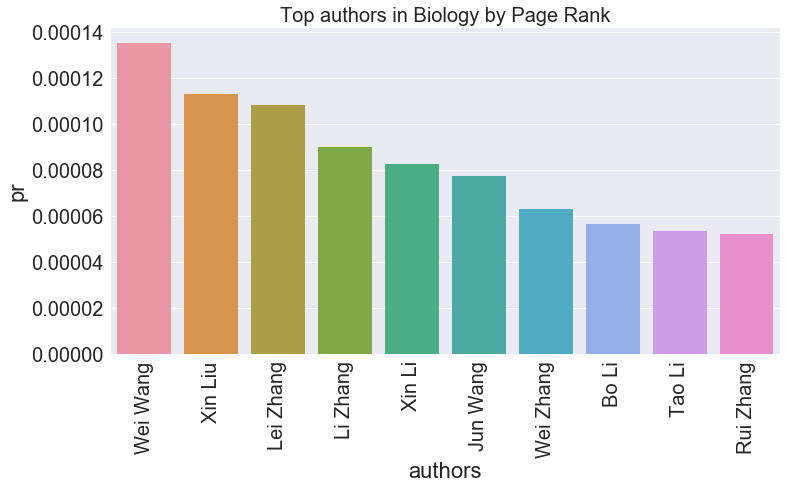

In [235]:
pr_bio = get_pr_auth_per_field(field = 'biology', threshold =5)


sns.set(rc={'figure.figsize':(12,6)})
sns.set(font_scale = 2)
sns.barplot(x='authors',y='pr', data=pr_bio[0:10]).set_title('Top authors in Biology by Page Rank',fontsize=20)
 
# Rotate x-labels
plt.xticks(rotation=90)

received field:statistics


C:\Users\Vaibhav\Anaconda3_DSF\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

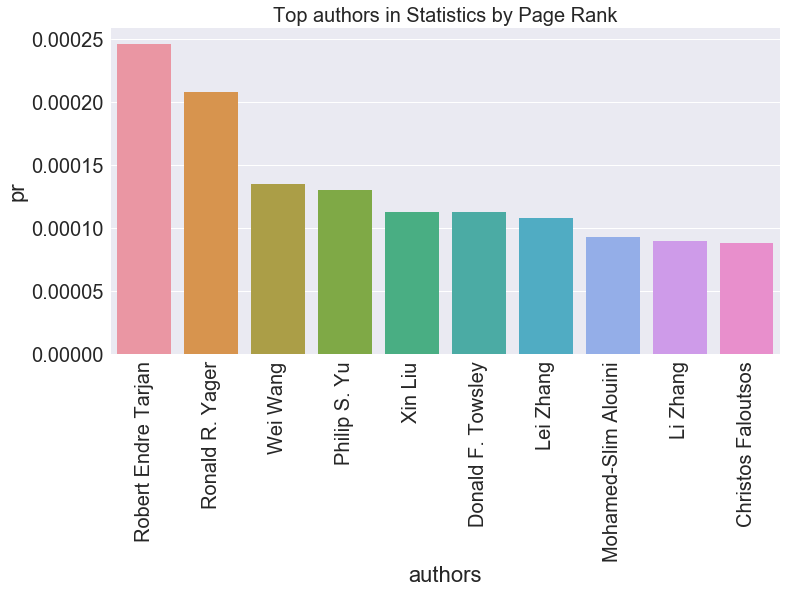

In [232]:
pr_stat = get_pr_auth_per_field(field = 'statistics', threshold =5)


sns.set(rc={'figure.figsize':(12,6)})
sns.set(font_scale = 2)
sns.barplot(x='authors',y='pr', data=pr_stat[0:10]).set_title('Top authors in Statistics by Page Rank',fontsize=20)
 
# Rotate x-labels
plt.xticks(rotation=90)

In [ ]:
def pagerankmodified(G,average_inc,paper_id_to_year,alpha=0.85, personalization=None,
             max_iter=100, tol=1.0e-6, nstart=None, weight='weight',dangling=None):
   
    if len(G) == 0:
        return {}

    if not G.is_directed():
        D = G.to_directed()
    else:
        D = G

    # Create a copy in (right) stochastic form
    W = nx.stochastic_graph(D, weight=weight)
    N = W.number_of_nodes()

    # Choose fixed starting vector if not given
    if nstart is None:
        x = dict.fromkeys(W, 1.0 / N)
    else:
        # Normalized nstart vector
        s = float(sum(nstart.values()))
        x = dict((k, v / s) for k, v in nstart.items())

    if personalization is None:
        # Assign uniform personalization vector if not given
        p = dict.fromkeys(W, 1.0 / N)
    else:
        missing = set(G) - set(personalization)
        if missing:
            raise NetworkXError('Personalization dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        s = float(sum(personalization.values()))
        p = dict((k, v / s) for k, v in personalization.items())

    if dangling is None:
        # Use personalization vector if dangling vector not specified
        dangling_weights = p
    else:
        missing = set(G) - set(dangling)
        if missing:
            raise NetworkXError('Dangling node dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        s = float(sum(dangling.values()))
        dangling_weights = dict((k, v/s) for k, v in dangling.items())
    dangling_nodes = [n for n in W if W.out_degree(n, weight=weight) == 0.0]

    # power iteration: make up to max_iter iterations
    for _ in range(max_iter):
        xlast = x
        x = dict.fromkeys(xlast.keys(), 0)
        danglesum = alpha * sum(xlast[n] for n in dangling_nodes)
        for n in x:
            # this matrix multiply looks odd because it is
            # doing a left multiply x^T=xlast^T*W
            #print(n)
            for nbr in W[n]:
                x[nbr] += alpha * xlast[n] * W[n][nbr][weight]
                if nbr in paper_id_to_year:
                    x[nbr] /= average_inc[paper_id_to_year[nbr]]
            
            x[n] += danglesum * dangling_weights[n] + (1.0 - alpha) * p[n]
            
        # check convergence, l1 norm
        err = sum([abs(x[n] - xlast[n]) for n in x])
        if err < N*tol:
            return x
    raise NetworkXError('pagerank: power iteration failed to converge '
                        'in %d iterations.' % max_iter)

In [ ]:
pagerank_score = pagerankmodified(G,average_inc,paper_id_to_year)
import json
with open('PageRank_New_Papers.txt', 'w') as file:
     file.write(json.dumps(pagerank_score)) # use `json.loads` to do the reverse

# Prediction of papers that will get popular in future using Machine Learning

In this section we are training a model on the DBLP dataset on features on following features:
1. Page rank average of authors
2. h-index average of authors

The test data has been taken from arxiv dataset using the XML based REST APi of arxiv: https://arxiv.org/help/api/user-manual
Testing data has been taken for the fields: AI, HCI, Stats and Networking.

In [112]:

def add_columns(train_df, author_pr_map, author_h_index_map, pr_page = pr_page):
    paper_pr = []
    for index, row in train_df.iterrows():
#         print(pr_page[row['id']])
        if row['id'] in pr_page:
            paper_pr.append(pr_page[row['id']])
        else:
            paper_pr.append(0)

    train_df['PageRank'] = paper_pr
    print(train_df['PageRank'].head())
    
    auth_pr = []
    auth_h_index = []
    for index, row in train_df.iterrows():
        auths=row['authors']
#         if(index%1000==0):
#             print(auths)
        pr_sum = 0
        pr_count = 0
        h_sum = 0
        h_count = 0
        pr_score = 0
        h_score = 0
        for a in auths:
            if a in author_pr_map:
                pr_sum+= author_pr_map[a]
                pr_count+=1
            if a in author_h_index_map:
                h_sum+= author_h_index_map[a]
                h_count+=1
        if pr_count == 0:
            pr_score = 0
        else:
            pr_score = float(pr_sum)/pr_count  
            
        if h_count == 0:
            h_score = 0
        else:
            h_score = float(h_sum)/h_count
        auth_pr.append(pr_score)
        auth_h_index.append(h_score)
    train_df['AuthorPageRankScore'] = auth_pr
    train_df['AuthorHIndexScore'] = auth_h_index
#     print(train_df['AuthorPageRankScore'].head())
    print(train_df.head())            

# author_h_index_map = get_author_h_index(author_papercitations_map)

add_columns(train_df, pr_auth, author_h_index_map, pr_page)

0    4.732288e-07
1    6.541798e-07
2    4.490645e-07
3    3.338994e-07
4    3.704188e-07
Name: PageRank, dtype: float64
['Guoping Pang', 'Lansun Chen']
['Vincent Wan', 'Steve Renals']
['Xueke Li', 'Jinnian Wang', 'Lifu Zhang', 'Taixia Wu', 'Hang Yang', 'Kai Liu', 'Hailing Jiang']
['Thomas C. Luu', 'Eugene D. Brooks', 'Abraham Szoke']
['Grace Zgheib', 'Iyad Ouaiss']
['Qi Guo', 'Yan Li', 'Tao Liu', 'Kun Wang', 'Guancheng Chen', 'Xiaoming Bao', 'Wentao Tang']
['Mauro Mezzini']
['Zi Lu', 'Sisi Wang', 'Xiaonan Li', 'Lihua Yang', 'Dong Yang', 'Dianshuang Wu']
['David Abercrombie', 'Fedor G. Pikus', 'Cosmin Cazan']
['Alice M. Johnson', 'Albert L. Lederer']
['Geert-Jan M. Kruijff', 'Jason Baldridge']
['Layachi Bentabet', 'Jiang Maodong']
['Nathan V. Roberts']
['Brian H. Tracey', 'Eric L. Miller', 'Yue Wu', 'Pradeep Natarajan', 'Joseph P. Noonan']
['Jiefei Ma', 'Alessandra Russo', 'Krysia Broda', 'Keith L. Clark']
['Jean-Claude Baron', 'Terry Jones']
['Satoshi Amamiya', 'Masaaki Izumi', 'Takan

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor




def train_LR_RF(train_df):
    features = ['AuthorPageRankScore', 'AuthorHIndexScore']#,'AuthorHIndexScore'
    # features = ['year', 'hour_of_day', 'distance_miles']
    X = train_df[features].values
    y = train_df['PageRank'].values
    y = y*1000
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model_LR = LinearRegression()
    model_LR.fit(X_train, y_train)
    y_predicted = model_LR.predict(X_test)
#     print((y_predicted))
#     print((y_train))


    #The coefficients of the linear equation aX1 + bX2 + cX3 + ... = Y
    print('Coefficients of Linear Regression : ', [(x,y) for x,y in zip(features,model_LR.coef_)])

    # The mean squared error of the linear regression model's predictions
    print("Mean squared error: %.20f" % mean_squared_error(y_test, y_predicted))

    # Variance of the prediction
    print('Variance : %.5f' % r2_score(y_test, y_predicted))
    
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y = rf.predict(X_test)
    print("Mean squared error RF: %.20f" % mean_squared_error(y_test, y))
    
    # Variance of the prediction
    print('Variance RF : %.5f' % r2_score(y_test, y))
#     print((y))
#     print((y_train))
    return model_LR, rf
    
print(train_df.head())
model_LR, model_RF = train_LR_RF(train_df)

   index                                            authors  \
0      0                        [Guoping Pang, Lansun Chen]   
1      1             [Anneliese von Mayrhauser, Ning Zhang]   
2      2            [Zheng Yan, Peng Zhang, Robert H. Deng]   
3      3  [Jarkko Kaleva, Petri Komulainen, Markku J. Ju...   
4      4                         [Yingnan Zhang, Qiao Wang]   

                                     id  n_citation  \
0  4aa69add-3978-480b-a1c0-d99a83d7e324           8   
1  4aa69b49-9bfc-49c3-81a7-7af5c215ca0e          50   
2  4aa69de5-c819-482e-a808-2b3f8b829008          53   
3  4aa6a255-c72c-4ccf-b1b8-c048ba39255b           0   
4  4aa6bae5-bbd9-46a1-944a-18ed700b72d5          50   

                                          references  \
0  [04754a28-6bf4-4d5d-8e42-2677d8564cdc, 33a877a...   
1  [2932090c-8204-4970-bd27-98a66155011c, 9479c8d...   
2  [012d9aaf-34d0-496a-99c0-f0fd15dd2984, 029be9a...   
3  [1322cb89-dda2-4625-8c80-6863810d5c3f, 1eddb4e...   
4  [0b480a

In [114]:
def load_test_df(csv_path='./test_data_arxiv_ai.csv', nrows=None, field='artificial intelligence'):
    test_df = pd.read_csv(csv_path, nrows=None)
    test_df['authors'] = test_df['authors'].fillna("[]")
#     test_df['references'] = train['references'].fillna("[]")
    test_df[['authors']] = test_df[['authors']].applymap(literal_eval)
#     train.reset_index(level=0, inplace=True)
#     train.head()
    test_df['dop'] = pd.to_datetime(test_df['dop'], format='%Y-%m-%d %H:%M:%S')
    test_df["year"] = test_df.dop.dt.year
    test_df = test_df.drop(columns=['dop'])
    field_list = []
    for i in range(0, len(test_df)):
        field_list.append(field)
    test_df['field'] = field_list
    return test_df
test_df = load_test_df()
test_df_CN = load_test_df('./test_data_arxiv_networking.csv', field = 'computer network')
test_df_HCI = load_test_df('./test_data_arxiv_HCI.csv', field = 'human computer interaction')
test_df_Stat = load_test_df('./test_data_arxiv_Statistics.csv', field = 'statistics')
test_df = test_df.append(test_df_CN, ignore_index=True)
test_df = test_df.append(test_df_HCI, ignore_index=True)
test_df = test_df.append(test_df_Stat, ignore_index=True)
test_df.head()
# add_columns_testdf(test_df, author_pr_map, author_h_index_map)

,arxiv_id,title,authors,ref,year,field
0,1811.11711v1,Neural probabilistic motor primitives for huma...,"[Josh Merel, Leonard Hasenclever, Alexandre Ga...",NaN,2018.0,artificial intelligence
1,1811.11707v1,Few-Shot Generalization Across Dialogue Tasks,"[Vladimir Vlasov, Akela Drissner-Schmid, Alan ...",NaN,2018.0,artificial intelligence
2,1811.11682v1,Experience Replay for Continual Learning,"[David Rolnick, Arun Ahuja, Jonathan Schwarz, ...",NaN,2018.0,artificial intelligence
3,1811.11623v1,Large Scale Audio-Visual Video Analytics Platf...,"[Alexander Schindler, Martin Boyer, Andrew Lin...",25th International Conference on MultiMedia Mo...,2018.0,artificial intelligence
4,1811.11522v1,Towards Decentralization of Social Media,"[Sarang Mahajan, Amey Kasar]",NaN,2018.0,artificial intelligence


In [115]:
def add_columns_testdf(test_df, author_pr_map, author_h_index_map):
    
    
    auth_pr = []
    auth_h_index = []
    for index, row in test_df.iterrows():
        auths=row['authors']
#         if(index%1000==0):
#             print(auths)
        pr_sum = 0
        pr_count = 0
        h_sum = 0
        h_count = 0
        pr_score = 0
        h_score = 0
        for a in auths:
            if a in author_pr_map:
                pr_sum+= author_pr_map[a]
                pr_count+=1
            if a in author_h_index_map:
                h_sum+=author_h_index_map[a]
                h_count+=1
        if pr_count == 0:
            pr_score = 0
        else:
            pr_score = float(pr_sum)/pr_count  
            
        if h_count == 0:
            h_score = 0
        else:
            h_score = float(h_sum)/h_count
        auth_pr.append(pr_score)
        auth_h_index.append(h_score)
    test_df['AuthorPageRankScore'] = auth_pr
    test_df['AuthorHIndexScore'] = auth_h_index
#     print(test_df['AuthorPageRankScore'].head())
#     print(test_df['AuthorHIndexScore'].head())            

# author_h_index_map = get_author_h_index(author_papercitations_map)

add_columns_testdf(test_df, pr_auth, author_h_index_map)
d=test_df.loc[test_df['title'] == 'The DARPA Twitter Bot Challenge']
print(d.authors)
test_df.head()

84
16
7852    [V. S. Subrahmanian, Amos Azaria, Skylar Durst...
Name: authors, dtype: object


,arxiv_id,title,authors,ref,year,field,AuthorPageRankScore,AuthorHIndexScore
0,1811.11711v1,Neural probabilistic motor primitives for huma...,"[Josh Merel, Leonard Hasenclever, Alexandre Ga...",NaN,2018.0,artificial intelligence,1.631715e-06,1.400000
1,1811.11707v1,Few-Shot Generalization Across Dialogue Tasks,"[Vladimir Vlasov, Akela Drissner-Schmid, Alan ...",NaN,2018.0,artificial intelligence,0.000000e+00,0.000000
2,1811.11682v1,Experience Replay for Continual Learning,"[David Rolnick, Arun Ahuja, Jonathan Schwarz, ...",NaN,2018.0,artificial intelligence,5.833619e-07,0.333333
3,1811.11623v1,Large Scale Audio-Visual Video Analytics Platf...,"[Alexander Schindler, Martin Boyer, Andrew Lin...",25th International Conference on MultiMedia Mo...,2018.0,artificial intelligence,6.468591e-07,0.500000
4,1811.11522v1,Towards Decentralization of Social Media,"[Sarang Mahajan, Amey Kasar]",NaN,2018.0,artificial intelligence,0.000000e+00,0.000000


In [116]:
def test(model, test_df):
    features = ['AuthorPageRankScore','AuthorHIndexScore']#,'AuthorHIndexScore'
    XTEST = test_df[features]
    y_pred_final = model.predict(XTEST)
#     y_pred_final *= 100000
    print((XTEST.head()))
    submission = pd.DataFrame(
    {'key': test_df.title, 'year': test_df.year, 'Auth_PR':test_df.AuthorPageRankScore, \
     'field':test_df.field, 'authHIndex':test_df.AuthorHIndexScore, 'authors': test_df.authors, 'Score': y_pred_final},
    columns = ['key','year','Auth_PR', 'authHIndex', 'authors','field', 'Score'])
    submission.to_csv('predictions_All_Fields.csv', index = False)
    
# submission = pd.DataFrame(
#     {'key': df_test.key, 'fare_amount': y_pred_final},
#     columns = ['key', 'fare_amount'])
# submission.to_csv('submission_lr.csv', index = False)
test(model_LR, test_df)
# test(model_RF, test_df)

   AuthorPageRankScore  AuthorHIndexScore
0         1.631715e-06           1.400000
1         0.000000e+00           0.000000
2         5.833619e-07           0.333333
3         6.468591e-07           0.500000
4         0.000000e+00           0.000000


In [ ]:
def storeTopTitlesFromPageRankScore(train_df, pagerank_score):
    result = list()
    count =0
    for w in sorted(pagerank_score, key= pagerank_score.get, reverse=True):
        rows = train_df.loc[train_df['id'] == w]
        for index,row in rows.iterrows():
    
            s = ",".join((str(row['id']),str(row['title']),str(row['year']),str(pagerank_score[w])))
            count = count +1
            result.append(s)
            print(s)

        if count > 100:
            break
    
    file = open('top100_oldPR_papers.txt', 'w')
    for t in result:
        file.write(str(t))
        file.write('\n')
        
    file.close()

In [ ]:
storeTopTitlesFromPageRankScore(train_df, pagerank_score)

In [ ]:
train_df = train_df.drop(columns=['index','abstract'])
train_df.to_csv('train_df.csv', index=False)

# Ranking of domains of publications

In [155]:
def rate_domains(pr_page):
    domains = ['artificial intelligence', 'statistics', 'mathematical optimization', 'combinatorics', 'real time computing',\
               'computer security','data mining', 'embedded system','distributed computing','human computer interaction',\
                'biology','database','information retrieval','electronic engineering','computer vision','fuzzy logic',\
              'machine learning','internet privacy','artificial neural network','psychology', \
               'cloud computing']
    domain_rank = {}
    domain_count = {}
    for d in domains:
        papers = get_per_field_papers(df=train_df, field=d)
        papers = papers.id.reset_index(drop=True)
        
        pr_sum = 0
        for paper in papers:
            pr_sum += pr_page[paper]
        pr_avg = pr_sum/len(papers)
        domain_rank[d] = pr_avg
        domain_count[d] = len(papers)
        
#     print(domain_rank)
    domain_df = []
    pr_df = []
    count_df = []
    for d in sorted(domain_rank, key=domain_rank.get, reverse=True):
        domain_df.append(d)
        pr_df.append(domain_rank[d])
        count_df.append(domain_count[d])
    df_result = pd.DataFrame({'domain':domain_df})
    df_score = pd.DataFrame({'score':pr_df})
    df_count = pd.DataFrame({'count':count_df})
    df_result['score'] =  df_score
    df_result['count'] =  df_count
    print(df_result)
    
        
rate_domains(pr_page)           
            

                        domain         score   count
0                  fuzzy logic  5.267538e-07    1365
1    artificial neural network  5.252845e-07    2197
2                combinatorics  5.119102e-07   37637
3                     database  5.083643e-07   23846
4              cloud computing  5.082579e-07     844
5                   statistics  5.064040e-07   20237
6    mathematical optimization  5.054782e-07  108926
7             machine learning  5.042490e-07   32500
8                      biology  5.029652e-07   11287
9        distributed computing  5.027616e-07   86339
10       information retrieval  5.014698e-07   14074
11         real time computing  5.010005e-07  102996
12     artificial intelligence  4.996918e-07  221813
13                 data mining  4.996474e-07   62157
14      electronic engineering  4.991917e-07   40165
15                  psychology  4.981610e-07   10784
16  human computer interaction  4.981516e-07   22160
17             computer vision  4.969523e-07  

# Time Analysis of diferent domains of publications

In [224]:
def field_time_analysis(papers, train_df=train_df, field='Artificial Intelligence' ):
#     print(train_df.head())
    train_df1 = train_df.loc[(train_df['year']>1970)]
    df_field = train_df1.loc[(train_df1['id'].isin(list(papers['id'])))]

    df_field_grouped = df_field.groupby(['year'],as_index = False).agg({ 'index' : ['count'] })
    # multiple line plot
#     num=0
#     for column in df_field_grouped.drop('year', axis=1):
#         num+=1
#         plt.plot(df_field_grouped['year'], df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)

#     # Add legend
#     plt.legend(loc=2, ncol=2)

#     # Add titles
#     plt.title("A (bad) Spaghetti plot", loc='left', fontsize=12, fontweight=0, color='orange')
#     plt.xlabel("Time")
#     plt.ylabel("Score")

    return df_field_grouped
                       
# print((ai_papers.reset_index()))
# ai_papers = ai_papers.reset_index()
fields = ['artificial neural network', 'calculus', 'economics', 'discrete mathematics', 'statistics',\
          'artificial intelligence']
stat_papers = get_per_field_papers(df=train_df, field='statistics')
stat_df = field_time_analysis(stat_papers, train_df, field='statistics')

ai_papers = get_per_field_papers(df=train_df, field='artificial intelligence')
ai_df = field_time_analysis(ai_papers, train_df, field='artificial intelligence')

ml_papers = get_per_field_papers(df=train_df, field='machine learning')
ml_df = field_time_analysis(ml_papers, train_df, field='machine learning')

eco_papers = get_per_field_papers(df=train_df, field='economics')
eco_df = field_time_analysis(eco_papers, train_df, field='economics')

dm_papers = get_per_field_papers(df=train_df, field='discrete mathematics')
dm_df = field_time_analysis(dm_papers, train_df, field='discrete mathematics')

calc_papers = get_per_field_papers(df=train_df, field='calculus')
calc_df = field_time_analysis(calc_papers, train_df, field='calculus')


Text(0,0.5,'Count')

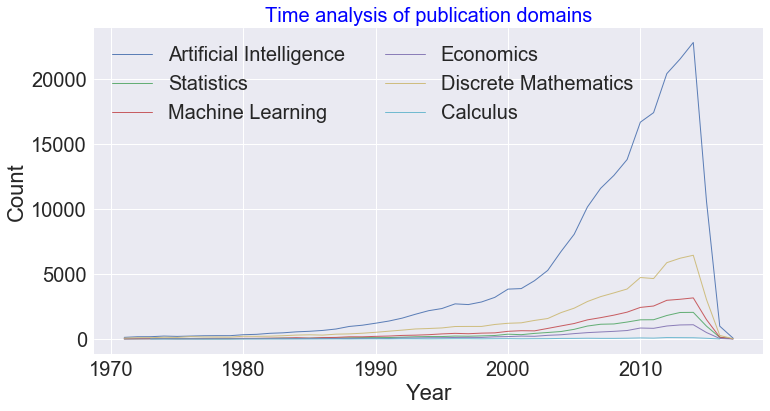

In [226]:
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')

plt.plot(ai_df['year'], ai_df['index']['count'], marker='', linewidth=1, alpha=0.9, label='Artificial Intelligence')
plt.plot(stat_df['year'], stat_df['index']['count'], marker='', linewidth=1, alpha=0.9, label='Statistics')
plt.plot(ml_df['year'], ml_df['index']['count'], marker='', linewidth=1, alpha=0.9, label='Machine Learning')
plt.plot(eco_df['year'], eco_df['index']['count'], marker='', linewidth=1, alpha=0.9, label='Economics')
plt.plot(dm_df['year'], dm_df['index']['count'], marker='', linewidth=1, alpha=0.9, label='Discrete Mathematics')
plt.plot(calc_df['year'], calc_df['index']['count'], marker='', linewidth=1, alpha=0.9, label='Calculus')
# Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("Time analysis of publication domains", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Year")
plt.ylabel("Count")


In [215]:
list(ai_df.columns.values)

[('year', ''), ('index', 'count')]

In [ ]:
#Reachability:
#for every paper, the reachability is calculated by the simple formula:
#rechability_paper = 1*num_papers_in_different_fields + 1*(if_num_papers_in_same_field > 1)
#This is primarily to determine the reach of a paper across different fields, and not its influence based on the number of papers that have cited it
reachability = []
dif_fields_list = []
titles = []
for index, row in top_ai.iterrows():
    cur_paper_id = row['id']
    num_similar = 0
    num_dif = 0
    orig = train_data.loc[train_data['id'] == cur_paper_id]
    titles.append(orig['title'].values[0])
    of1 = orig['F1'].values[0]
    of2 = orig['F2'].values[0]
    of3 = orig['F3'].values[0]
    set1 = set([of1,of2,of3])
    fset = set([of1,of2,of3])
    for x in DG.in_edges(cur_paper_id):
        cur_node = x[0]
        cur_row = train_data.loc[train_data['id'] == cur_node]
        
        nf1 = cur_row['F1'].values[0]
        nf2 = cur_row['F2'].values[0]
        nf3 = cur_row['F3'].values[0]
        set2 = set([nf1,nf2,nf3])
        
        common = set1-(set1-set2)
        if(len(common)<2):
            num_dif = num_dif + 1
            fset.add(nf1)
            fset.add(nf2)
            fset.add(nf3)
        else:
            num_similar = 1
    rval = num_dif+num_similar
    reachability.append(rval)
    dif_fields_list.append(list(fset))
    fset.clear()
    #print(rval)
    #print("----------------")

top_ai['reach'] = reachability
top_ai['reach_fields'] = dif_fields_list
top_ai['title'] = titles
print(top_ai)        